In this notebook we will attempt to learn how to construct and train a deep neural network from scratch to predict the handwritten digits. For this task we will perform the following:
- download and check the data
- prepare the dataset for training
- train the baseline model
- process to develop a better model
- analyze results

First, we import all the libraries we need:

In [1]:
#!pip install -Uqq fastai

In [2]:
!pip install fastbook

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 kB 21.4 MB/s eta 0:00:00


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

from pathlib import Path

import numpy as np
import pandas as pd

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch.utils.data import SubsetRandomSampler

# fastai
#from fastai.vision.all import *
#from fastbook import *

Nest, we define global variables and plot style:

In [4]:
# Plotting style
plt.style.use('ggplot')

# Global variables
DATA_DIR = Path('/kaggle/working/data/')

# About the dataset

## Download the dataset

To train anything we first need the data. For this project we will use the famous [MNIST dataset](https://pytorch.org/vision/stable/generated/torchvision.datasets.MNIST.html#torchvision.datasets.MNIST) comprised of images of digits from 0 to 9 where our task is to predict the digit based on the image provided. The dataset is already provided in the `dataset` module of `torchvision` library. To view which datasets are available see the [link](https://pytorch.org/vision/stable/datasets.html).

To download the dataset we need to provide the following arguments: `root`: where to save the downloaded files, `train`: should the train dataset be downloaded, and `download` whether to download the dataset. Note that if the data already exists locally in the provided `root` argument then the data will not be downloaded. The dataset will be processed as PyTorch `DataSet`.

In [5]:
# Train set
data_train = datasets.MNIST(root=DATA_DIR, train=True, download=True,
                            transform=ToTensor())
# Test set
data_test = datasets.MNIST(root=DATA_DIR, train=False, download=True,
                           transform=ToTensor())

print(f'Train data: {len(data_train)}')
print(f'Test data: {len(data_test)}')

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /kaggle/working/data/MNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/data/MNIST/raw

Train data: 60000
Test data: 10000


- `root`: file directory into which the data is downloaded
- `train`: should the training data set be downloaded
- `download`: should we download the data. If the data already exists in the `root` it will not be downloaded
- `transform = ToTensor()`: "Convert a PIL Image or ndarray to tensor and scale the values accordingly." ([Ref.](https://pytorch.org/vision/stable/generated/torchvision.transforms.ToTensor.html#torchvision.transforms.ToTensor))

Let's check that the data transformation was applied:

In [6]:
img, label = data_train[0]
print(type(img))

<class 'torch.Tensor'>


Let's check the size of the datasets:

In [7]:
print(f'Train: {data_train.data.shape}')
print(f'Test: {data_test.data.shape}')

Train: torch.Size([60000, 28, 28])
Test: torch.Size([10000, 28, 28])


So in total there are 70000 images of handrwitten digits, where each is of size 28 by 28 pixels. Since the data is processed as PyTorch dataset then we know that each element of `data_train` is a tuple of inputs and labels.

Let's see visualize some of the images look like:

In [8]:
def show_sample(data):
    """Ref: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html"""
    fig = plt.figure(figsize=(7,7))
    cols, rows = 3,3
    for i in range(1, cols*rows+1):
        sample_idx = torch.randint(len(data), size=(1,)).item()
        # Get image and the corresponding label
        img, label = data[sample_idx]
        fig.add_subplot(rows,cols,i)
        plt.imshow(img.squeeze(), cmap='Blues')
        plt.title(f'Label: {label}', size=10)
        plt.axis("off")
    plt.show()

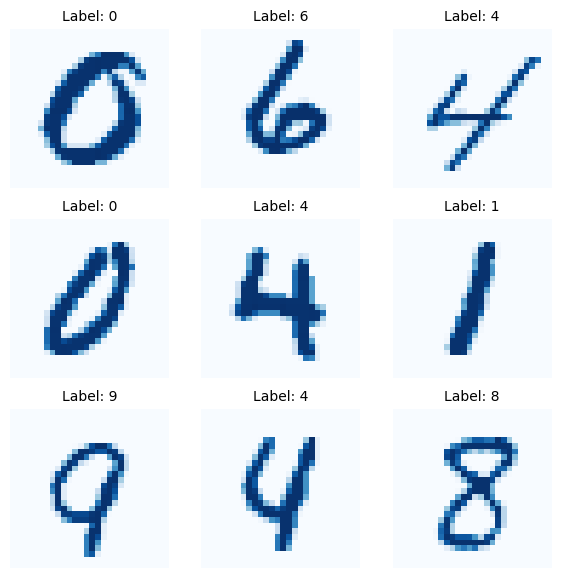

In [9]:
show_sample(data_train)

Each of the images is composed of pixels ranging from 0 to 255, where 0 represents white and 255 black, but since we applied the `ToTensor()` transform while downloading the data all of the pixel values will be in the range of `(0,1)`. Let's see what we mean by that:

In [10]:
# Extract the first image and its label from the dataset
img, label = data_train[0]
print(f'Image dimension: {img.shape}')
print(f'Label: {label}')

Image dimension: torch.Size([1, 28, 28])
Label: 5


So the image size is 28 by 28 pixels and the first image should represent digit 5. Let's see the pixel data with gradient colors for better visualization. We will use pandas `style` to apply the gradient effect. Since our image is of rank 3 in order to convert it to a pandas dataframe we need to remove the first dimension. We will do this using the `numpy` `squeeze()` which removes axes of length 1. Below image gives us the normalized pixel representation of the first digit image in the training sample. The label for this image is 5.

In [11]:
dfimg = pd.DataFrame(img.squeeze().numpy())
dfimg.style.set_properties(**{'font-size':'6pt'}).background_gradient('Blues')

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.011765,0.070588,0.070588,0.070588,0.494118,0.533333,0.686275,0.101961,0.650980,1.000000,0.968627,0.498039,0.000000,0.000000,0.000000,0.000000
6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.117647,0.141176,0.368627,0.603922,0.666667,0.992157,0.992157,0.992157,0.992157,0.992157,0.882353,0.674510,0.992157,0.949020,0.764706,0.250980,0.000000,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.192157,0.933333,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.992157,0.984314,0.364706,0.321569,0.321569,0.219608,0.152941,0.000000,0.000000,0.000000,0.000000,0.000000
8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.070588,0.858824,0.992157,0.992157,0.992157,0.992157,0.992157,0.776471,0.713726,0.968627,0.945098,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.313726,0.611765,0.419608,0.992157,0.992157,0.803922,0.043137,0.000000,0.168627,0.603922,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


## Prepare dataset for training

Previously we have downloaded two datasets, training and testing. To be able to deduce whether our model is overfitting during training we need another dataset, namely, validation set. The validation set will show us how our model performs on out-of-sample data, i.e. data that have not been used in training.

We will generate the validation dataset from the training dataset since it is much bigger than the given test set, naturally.

For this problem, we can assume that the images in the dataset are independent and don't have any underlying structure, like time, we should think about when splitting the dataset. The only aspect we should worry about is the distribution of digits in all samples. Ideally, we want the digits to be distributed in the same way in all samples, so when creating the dataset for validation we should keep this in mind. For example, if we would have a training set of a very small number of say digits 3 but a large sample of digits 3 in the test set then the model has a very limited information scope to learn from, but it is expected to know 3s very well in out-of-sample settings.

So first, let's check the distributions of labels in our datasets. We can use `class_to_idx` to get the dictionary of labels in our dataset.

In [12]:
# Get mapping of target IDs
print(data_train.class_to_idx)

{'0 - zero': 0, '1 - one': 1, '2 - two': 2, '3 - three': 3, '4 - four': 4, '5 - five': 5, '6 - six': 6, '7 - seven': 7, '8 - eight': 8, '9 - nine': 9}


In [13]:
# Define custom colors for the labels
import matplotlib.colors as mcolors

colors = ["#D9D2D8","#F2BBC9", "#BF849A", "#8C7A89", "#9AC7D9", 
          "#82C0D9", "#7DABB3", "#8F9FBF", "#737F99", "#566073"]
cmap = mcolors.ListedColormap(colors)

Plot the distributions of labels for training and test sets:

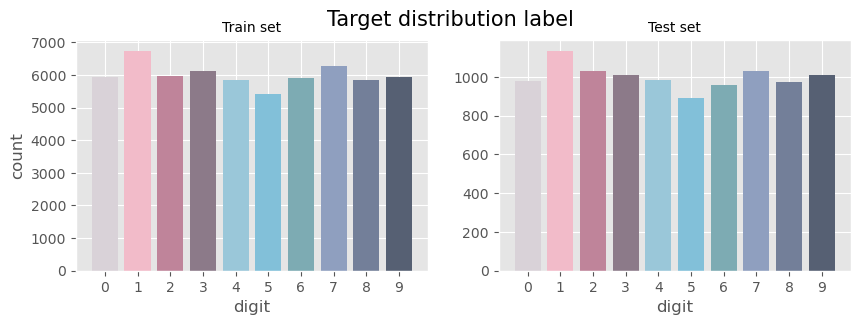

In [14]:
df = pd.DataFrame(pd.Series(data_train.targets).value_counts().reset_index())
df.columns = ['digit', 'count']
df.sort_values('digit', inplace=True)
dft = pd.DataFrame(pd.Series(data_test.targets).value_counts().reset_index())
dft.columns = ['digit', 'count']
dft.sort_values('digit', inplace=True)
fig,_=plt.subplots(1,2, figsize=(10,3))
plt.suptitle('Target distribution label', size=15)
plt.subplot(1,2,1)
plt.bar('digit', 'count',data=df, color=cmap(df.digit))
plt.title('Train set', size=10)
plt.xlabel('digit')
plt.xticks(range(len(df.digit)), df.digit)
plt.ylabel('count')
plt.subplot(1,2,2)
plt.bar('digit', 'count',data=dft, color=cmap(dft.digit))
plt.title('Test set', size=10)
plt.xlabel('digit')
plt.xticks(range(len(dft.digit)), dft.digit)
plt.show()

We can see from the above figures that the target distributions for both training and test sets are similar and all digits are represented relatively in a balanced structure, which means we can just split the training data randomly into training and validation sets. Note that if the sample is not balanced then when splitting the sample we should preserve the sample imblance.

We will use `SubsetRandomSampler` to select the data. The `SubsetRandomSampler` uses indices from the original dataset to select subsets of data. So, first we need to define which indices are for the training sample and which are to be used for the validation sample. The steps are:

[Ref](https://towardsdatascience.com/pytorch-basics-sampling-samplers-2a0f29f0bf2a)

In [15]:
# Step 1 - Length of train dataset from which we are splitting the data
Nd = len(data_train); print(f'Dataset length: {Nd}')

# Step 2 - Create a shuffled list of training indices
Nd_idx = list(range(Nd))
np.random.shuffle(Nd_idx)
print(f'Shuffled indices {Nd_idx[:5]}')

# Step 3 - Define percentage of indices for the training sample
# to compute number of indices to be included in the training sample
train_pct = 0.7
Nt = int(np.floor(train_pct * Nd))

# Step 4 - Split the indices into training and validation
# and pass the indices to the SubsetRandomSampler
tr_idx, vl_idx = Nd_idx[:Nt], Nd_idx[Nt:]

# SubsetRandomSampler(indices): Samples elements randomly from a given list of indices, without replacement.
tr_sampler = SubsetRandomSampler(tr_idx)
vl_sampler = SubsetRandomSampler(vl_idx)

print(f'\nTrain idx length: {len(tr_sampler)}')
print(list(tr_sampler)[:5])
print(f'\nValid idx length: {len(vl_sampler)}')
print(list(vl_sampler)[:5])

Dataset length: 60000
Shuffled indices [29871, 30961, 56031, 22460, 32241]

Train idx length: 42000
[15708, 51837, 41139, 50106, 20961]

Valid idx length: 18000
[26797, 40786, 24795, 8344, 59076]


Now, that we have the samplers for training and validation, we can create the objects for each dataset which will contain all the information used in the training process with respect to the input data.

In order to train the model using PyTorch there are two basic requirements in regards to the input data:
1. the dataset has to be in the form of a tuple with the structure (input, label) where each is a tensor
2. the input data should be stored in batches, i.e. the input data is iterable over batches.

Note that the initial data is already in form of tuples, as we saw previously. To create the iterable batches we will use a PyTorch object called `DataLoader` which takes a Python collection and converts it to an iterator based on batches. From the PyTorch documentation we have:

> Data loader. Combines a dataset and a sampler, and provides an iterable over the given dataset. [Ref]()

Since we have a dataset and samplers for each subset we can create dataloaders for each sample:

In [16]:
# Define number of mini-batches
no_batches = 64

Let's check what we have got in training and validation dataloaders. We also need to check whether there are any partial batches, i.e. leftover samples when constructing mini-batches. Note that there is an option in `DataLoader` called `drop_last` to drop any such letfovers.

In [17]:
def check_batches(sampler, batch_size):
    
    # Number of samples to expect in the final dataloader
    no_samples = len(sampler)
    
    # Number of batches to expect in the final dataloader
    no_batches = int(np.ceil(no_samples / batch_size))
    print(f'Number of batches total: {no_batches}')
    
    # Samples in the last batch (leftover samples)
    lb_samples = no_samples % batch_size
    
    if lb_samples != 0:
        no_batches -= 1
    
    print(f'Full batches: {no_batches}')
    if lb_samples != 0:
        print(f'Samples in partial batch: {lb_samples}')
    
    return no_batches, lb_samples

Let's check for training and validation sample:

In [18]:
print('Training sample')
tr_batches, tr_lb_samples = check_batches(tr_sampler, no_batches)
print('\nValidation sample')
vl_batches, vl_lb_samples = check_batches(vl_sampler, no_batches)

Training sample
Number of batches total: 657
Full batches: 656
Samples in partial batch: 16

Validation sample
Number of batches total: 282
Full batches: 281
Samples in partial batch: 16


Note that we can not use `shuffle=True` when using `SubsetRandomSampler()`. 

In [19]:
# Training dataloader
dl_train = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=tr_sampler)

# Validation dataloader
dl_valid = torch.utils.data.DataLoader(data_train, batch_size=no_batches, shuffle=False, sampler=vl_sampler)

# Test dataloader
dl_test = torch.utils.data.DataLoader(data_test, batch_size=no_batches, shuffle=True)

To check the size of the dataloader we can use `len()` which will give us the number of batches created for each dataset.

In [20]:
print(f'Training batches: {len(dl_train)}')
print(f'Validation batches: {len(dl_valid)}')
print(f'Test batches: {len(dl_test)}')

Training batches: 657
Validation batches: 282
Test batches: 157


The numbers for the batches from the dataloaders align with what we have calculated from the samplers. Finally let's check the shape of one batch:

In [21]:
for batch in dl_train:
    X, y = batch
    print(f'X shape: {X.shape}')
    print(f'y shape: {y.shape}')
    break

X shape: torch.Size([64, 1, 28, 28])
y shape: torch.Size([64])


# Training - Baseline Model

Now that we have our dataloaders ready we need to think about what other components we need to train a neural network. The components we need to consider are the following:
1. training device: GPU or CPU
2. model architecture
3. hyper-parameters
  - loss function
  - optimizer and the learning rate
  - metric

All of the components depend on the project at hand and can be different given different data structure, project goals, etc. In the sections below we consider each separately:

## Define the device for training

We can train our model either on CPU or GPU whichever is available. It is widely known that deep learning models train faster on the GPU to utilize the ability of numerous parallel computations at one time. To see what is available on the current computer we can run the following command, which we save as an object to be used later in the training loop.

In [22]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Using {device} device!')

Using cpu device!


## Model architecture

We start to expore with a simple neural network with linear layers. This will provide a fast baseline to check that our modeling pipeline works. Later on, we will iterate on it to develop a better model. So first, we define the class for model architecture by inheriting from the PyTorch `nn.Module`. In the `__init__` function we define all the layers of the neural network and in the `forward` function we define how the data will pass through the defined network.

In [23]:
class SimpleLNN(nn.Module):
    """
    A simple linear neural network with 2 linear layers
    and an output layer with softmax activation function.
    
    in_shape (tuple): (height, width)
    n_out (int): number of outputs of the model
    """
    
    def __init__(self, in_shape:tuple, n_out:int):
        super().__init__()
        self.in_shape = in_shape
        H, W = self.in_shape
        self.n_out = n_out
        self.flatten = nn.Flatten()
        self.linear_stack = nn.Sequential(
            nn.Linear(H*W, 512),
            nn.ReLU(),
            nn.Linear(512, self.n_out),
        )
        self.softmax = nn.Softmax(dim=1)
        
        
    def forward(self, x):
        x = self.flatten(x)
        x = self.linear_stack(x)
        x = self.softmax(x)
        
        return x

Initialize the model and send to device:

In [24]:
model = SimpleLNN(in_shape=(28,28), n_out=10).to(device)
print(model)

SimpleLNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
  (softmax): Softmax(dim=1)
)


Given our simple neural network let's see how many parameters we have to train per each layer:

In [25]:
def cnt_params(model, show_per_layer:bool=True):
    """
    Get the number of model parameters for the instantiated model class.
    If show_per_layer then print info for each layer.
    """

    if show_per_layer:
        print('-'*75)
        print(f'PARAMETER INFORMATION PER LAYER')
        print('•'*75)
        for name, param in model.named_parameters():
            if param.ndim < 2: 
                in_fts = param.ndim
            else:
                in_fts = param.shape[1]
            out_fts = param.shape[0]
            print(f"Layer: {name}  | InP: {in_fts}  | OutP: {out_fts}  |  CntParams: {in_fts*out_fts}")
    
    total_cnt_params = sum([x.reshape(-1).shape[0] for x in model.parameters()])
    print('-'*75)
    print(f'Total number of parameter: {total_cnt_params}')
    print('-'*75)

    return total_cnt_params

In [26]:
_ = cnt_params(model)

---------------------------------------------------------------------------
PARAMETER INFORMATION PER LAYER
•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••••
Layer: linear_stack.0.weight  | InP: 784  | OutP: 512  |  CntParams: 401408
Layer: linear_stack.0.bias  | InP: 1  | OutP: 512  |  CntParams: 512
Layer: linear_stack.2.weight  | InP: 512  | OutP: 10  |  CntParams: 5120
Layer: linear_stack.2.bias  | InP: 1  | OutP: 10  |  CntParams: 10
---------------------------------------------------------------------------
Total number of parameter: 407050
---------------------------------------------------------------------------


## Hyperparameters

In this project we are trying to classify images of handwritten digits, hence we are trying to predict 10 diferent classes. We need to choose a loss function which is suited for classification problems.

In [27]:
loss_fun = nn.CrossEntropyLoss()

In [28]:
lr_rate = 1e-3

In [29]:
optimizer = torch.optim.SGD(model.parameters(), lr=lr_rate)

### Training Loop 

Now that we have all the training components we can combine everything into a training loop. We will define a function for training and validation which will run given the number of epochs defined. To make the whole process more concise and clear first we define a training loop for one iteration through the data (one epoch), which we can then use to define a complete training function over all epochs.

In [30]:
def train_epoch(dataloader, model, loss_fun, optimizer, 
                lr_rate, device, print_cnt=100):
    """
    Training step for one batch
    """
    # Define where to save training results
    loss_train = 0
    accuracy_train = 0
    
    # Initialize training mode
    model.train()
    
    # Number of batches
    Nbatches = len(dataloader)
    
    # Loop through the batches in the dataloader
    for batch, (X,y) in enumerate(dataloader):
        
        # --- FORWARD PASS ---
        # Input data sent to device
        X, y = X.to(device), y.to(device)
        
        # Model output
        outputs = model(X)
        
        # Model prediction - class
        _,preds = torch.max(outputs.data,1)

        # Model loss & accuracy
        loss = loss_fun(outputs, y)
        correct_preds = (preds == y).sum().item()
        accuracy = correct_preds/len(y)
        
        # --- BACKPROPAGATION ---
        # Clear the gradients
        optimizer.zero_grad()

        # Compute the gradients
        loss.backward()
        
        # Update the parameters
        optimizer.step()
        
        # --- SAVE & PRINT RESULTS ---
        # Save results of every batch
        loss_train += loss.item()
        accuracy_train += accuracy

        # Print results of every 50th batch
        if print_cnt:
            if batch % print_cnt == 0:
                print(f'Batch: {batch+1}/{Nbatches}   Loss: {loss.item()}   Accuracy:{accuracy}')
    
    # Average the results
    loss_train /= Nbatches
    accuracy_train /= Nbatches

    return loss_train, accuracy_train

The above function `train` provides the general training sequence of steps:
- After the model trains for one epoch, we would like to see the results of that training. So we need to define where to save that information. Values of interest are loss and accuracy.
- Calling `model.train()` propels our defined architecture into action by setting the model into a training state and enabling some layers to behave in a specific way.
- For clarity we compute the number of batches, `Nbatches`, which we will use to average the final results of training.
- To train the model we loop through all the batches in the dataloader and compute the forward and backward pass
- We add the batch loss to `loss_train`. Note that the `loss.item()` gives the average loss for all samples in the corresponding batch. To get the average loss for the epoch we need to divide the accumulated batch losses with the number of batches used during training.
- To compute the accuracy we need to
  - get the index of the class with the highest probability - `torch.max(X, dim=1)`
  - sum all instances where the predicted and target class are equal to get the number of correct predictions
  - to get the percentage we divide by the number of samples in the batch.

Similarly, we can define the validation function:

In [31]:
def validate_epoch(dataloader_valid, model, loss_fun, device, print_cnt=100):
    """Model validation during training"""
    
    # Define where to save training results
    loss_valid = 0
    accuracy_valid = 0
    
    # Number of batches
    Nbatches = len(dataloader_valid)
    
    # Set the evaluation mode
    model.eval()
    
    with torch.no_grad():
        for batch, (Xv,yv) in enumerate(dataloader_valid):
        
            # --- FORWARD PASS ---
            # Input data sent to device
            Xv, yv = Xv.to(device), yv.to(device)

            # Model output
            outputs = model(Xv)

            # Model prediction - class
            _,preds = torch.max(outputs.data,1)

            # Model loss & accuracy
            loss = loss_fun(outputs, yv)
            correct_preds = (preds == yv).sum().item()
            accuracy = correct_preds/len(yv)

            # --- SAVE & PRINT RESULTS ---
            # Save results of every batch
            loss_valid += loss.item()
            accuracy_valid += accuracy

            # Print results of every 50th batch
            if print_cnt:
                if batch % print_cnt == 0:
                    print(f'Batch: {batch+1}/{Nbatches}   Loss: {loss.item()}   Accuracy:{accuracy}')
    
        # Average the results
        loss_valid /= Nbatches
        accuracy_valid /= Nbatches

    return loss_valid, accuracy_valid

Difference between the validation and training step is that in the validation step we are only computing the forward based on the trained model in the training step; hence no need for backpropagation since we are not updating any parameters. We simply want to deduce how well our model for a given epoch is doing on unseen (during training) data.

Now, we can combine both functions into a final training loop:

In [32]:
def training(dataloader_train, dataloader_valid, no_epochs,
             model, loss_fun, optimizer, lr_rate, device, print_cnt=None):
    """Model training"""
    
    loss_train_epoch = [0]*no_epochs
    accuracy_train_epoch = [0]*no_epochs
    loss_valid_epoch = [0]*no_epochs
    accuracy_valid_epoch = [0]*no_epochs
    
    for i in range(no_epochs):
        loss_train, accuracy_train = train_epoch(dataloader_train, model, loss_fun, optimizer, lr_rate, device,print_cnt)
        loss_valid, accuracy_valid = validate_epoch(dataloader_valid,model, loss_fun, device,print_cnt)
        
        loss_train_epoch[i] = loss_train
        accuracy_train_epoch[i] = accuracy_train
        loss_valid_epoch[i] = loss_valid
        accuracy_valid_epoch[i] = accuracy_valid
        
        print(f'EPOCH: {i+1}/{no_epochs}  Train Loss: {loss_train} Train Accuracy:{accuracy_train} // Valid Loss: {loss_valid}  Valid Accuracy: {accuracy_valid}')
            
    return loss_train_epoch, accuracy_train_epoch, loss_valid_epoch, accuracy_valid_epoch
    

In [33]:
no_epochs = 2
model_results = training(dl_train, dl_valid, no_epochs, model, loss_fun, optimizer, lr_rate, device)

EPOCH: 1/2  Train Loss: 2.301271475976279 Train Accuracy:0.10992199391171995 // Valid Loss: 2.3005262435750757  Valid Accuracy: 0.13259086879432624
EPOCH: 2/2  Train Loss: 2.2996239364600797 Train Accuracy:0.17589421613394216 // Valid Loss: 2.2988589841423304  Valid Accuracy: 0.21420656028368795


# Training - Model CNN

- normalize input data (substract the mean and divide by stdev